In [17]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [18]:
!pwd

/home/timjab92/code/timjab92/cryptotrading-indicator/notebooks


In [19]:
model = load_model("../model.joblib")

In [39]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
        data[f'dist_ema{t}'] = data['log_close'] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data['log_close'] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [45]:
x_gecko = get_xgecko()

In [46]:
x_gecko.shape

(1, 60, 1)

In [24]:
data_train_scaled, scaler = minmaxscaling(feature_engineer(get_train_data())[['log_close']])

In [25]:
pred = model.predict(x_gecko)

In [26]:
pred

array([[0.9690555]], dtype=float32)

In [27]:
pred = np.exp(scaler.inverse_transform(pred))

In [28]:
pred[0][0]

47757.633

In [40]:
data = feature_engineer(get_train_data())
data.dropna(inplace=True)
data = data.iloc[1: , :]

In [41]:
data.drop(columns=['open','high','low','close'], inplace = True)

In [42]:
data

,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema20,...,dist_ema55,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,
2012-01-11 08:00:00,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,0.051354,1.859967,0.089854,1.874226,...,0.124971,65.970885,37.306777,24.696599,1.890427,1.981574,1.799280,-0.031753,0.150541,-0.595712
2012-01-11 12:00:00,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,0.064614,1.869149,0.105727,1.884142,...,0.142476,68.023084,51.197785,37.636130,1.898878,1.988336,1.809419,-0.013460,0.165457,0.019896
2012-01-11 16:00:00,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,0.024063,1.874676,0.064040,1.889500,...,0.101042,62.193690,50.078456,46.194339,1.902687,1.992116,1.813258,-0.053400,0.125458,0.575566
2012-01-11 20:00:00,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,0.026437,1.880305,0.065605,1.895023,...,0.102941,62.875361,44.821949,48.699397,1.906934,1.996089,1.817779,-0.050179,0.128131,1.783596
2012-01-12 04:00:00,8.800000,1.938742,1.938742,1.938742,1.938742,1.922444,0.016298,1.884900,0.053841,1.899292,...,0.091148,61.681954,33.031877,42.644094,1.909735,1.999206,1.820264,-0.060465,0.118477,0.058328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,1.697971,10.794844,10.795222,10.794435,10.794853,10.792529,0.002323,10.775250,0.019603,10.781677,...,0.041530,62.080327,36.210154,50.235845,10.777789,10.840219,10.715358,-0.045367,0.079495,2.306553
2021-08-22 16:00:00,0.463362,10.791204,10.791498,10.790859,10.791202,10.792325,-0.001123,10.776432,0.014771,10.782584,...,0.036527,59.525060,19.004941,36.146357,10.782060,10.834660,10.729461,-0.043457,0.061742,-0.727108
2021-08-22 20:00:00,0.605696,10.795610,10.795982,10.795279,10.795660,10.792838,0.002822,10.777856,0.017804,10.783830,...,0.039521,61.603611,5.196078,20.137058,10.786118,10.828258,10.743977,-0.032598,0.051684,0.307177


In [32]:
df = pd.DataFrame(data[['log_close','vol_roc']])

In [33]:
# for i in [12, 26, 20, 50, 34, 55]:
#     df[f'dist_ema{i}'] = data['log_close'] - data[f'ema{i}']

In [34]:
# for i in ['bollinger_up', 'bollinger_down']:
#     df[f'dist_{i}'] = data['log_close'] - data[i]

<AxesSubplot:>

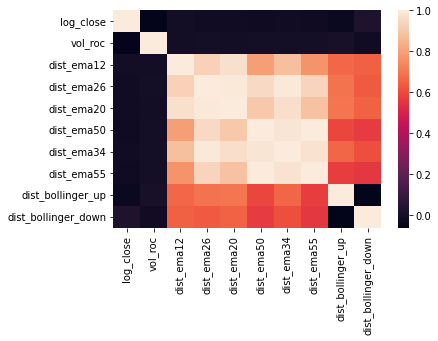

In [43]:
import seaborn as sns
sns.heatmap(df.corr())

In [61]:
df.corr()

,log_close,vol_roc,diff_ema12,diff_ema26,diff_ema20,diff_ema50,diff_ema34,diff_ema55,dist_bollinger_up,dist_bollinger_down
log_close,1.000000,-0.053434,-0.007541,-0.012104,-0.010318,-0.016966,-0.014074,-0.017666,-0.032238,0.023379
vol_roc,-0.053434,1.000000,-0.006818,-0.005782,-0.006052,-0.004997,-0.005502,-0.004850,0.006612,-0.013916
diff_ema12,-0.007541,-0.006818,1.000000,0.929619,0.968226,0.790229,0.878177,0.767015,0.663608,0.646884
diff_ema26,-0.012104,-0.005782,0.929619,1.000000,0.991453,0.948929,0.991076,0.933872,0.687086,0.633005
diff_ema20,-0.010318,-0.006052,0.968226,0.991453,1.000000,0.903616,0.965808,0.884605,0.696119,0.649320
diff_ema50,-0.016966,-0.004997,0.790229,0.948929,0.903616,1.000000,0.981750,0.998873,0.593517,0.567905
diff_ema34,-0.014074,-0.005502,0.878177,0.991076,0.965808,0.981750,1.000000,0.971870,0.660000,0.608393
diff_ema55,-0.017666,-0.004850,0.767015,0.933872,0.884605,0.998873,0.971870,1.000000,0.572933,0.558176
dist_bollinger_up,-0.032238,0.006612,0.663608,0.687086,0.696119,0.593517,0.660000,0.572933,1.000000,-0.059661
dist_bollinger_down,0.023379,-0.013916,0.646884,0.633005,0.649320,0.567905,0.608393,0.558176,-0.059661,1.000000


In [ ]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [62]:
df.keys()

Index(['log_close', 'vol_roc', 'diff_ema12', 'diff_ema26', 'diff_ema20',
       'diff_ema50', 'diff_ema34', 'diff_ema55', 'dist_bollinger_up',
       'dist_bollinger_down'],
      dtype='object')

In [64]:
data[['log_close', 'vol_roc', 'ema12','ema26','ema20','ema50','ema34','ema55', 'bollinger_up','bollinger_down']].corr()

,log_close,vol_roc,ema12,ema26,ema20,ema50,ema34,ema55,bollinger_up,bollinger_down
log_close,1.000000,-0.053434,0.999922,0.999814,0.999861,0.999619,0.999750,0.999576,0.999562,0.999617
vol_roc,-0.053434,1.000000,-0.053340,-0.053300,-0.053316,-0.053251,-0.053281,-0.053243,-0.053555,-0.053063
ema12,0.999922,-0.053340,1.000000,0.999960,0.999984,0.999813,0.999917,0.999777,0.999729,0.999762
ema26,0.999814,-0.053300,0.999960,1.000000,0.999994,0.999938,0.999992,0.999915,0.999768,0.999769
ema20,0.999861,-0.053316,0.999984,0.999994,1.000000,0.999896,0.999971,0.999867,0.999767,0.999778
ema50,0.999619,-0.053251,0.999813,0.999938,0.999896,1.000000,0.999975,0.999998,0.999666,0.999670
ema34,0.999750,-0.053281,0.999917,0.999992,0.999971,0.999975,1.000000,0.999959,0.999749,0.999744
ema55,0.999576,-0.053243,0.999777,0.999915,0.999867,0.999998,0.999959,1.000000,0.999632,0.999643
bollinger_up,0.999562,-0.053555,0.999729,0.999768,0.999767,0.999666,0.999749,0.999632,1.000000,0.999130
bollinger_down,0.999617,-0.053063,0.999762,0.999769,0.999778,0.999670,0.999744,0.999643,0.999130,1.000000


# redefining get_xy

In [56]:
LENGTH = 60
HORIZON = 1
SELECTED_FEATURES=['log_price']

In [57]:
def get_xy(data_train_scaled, length=LENGTH, horizon=HORIZON):
    y_train = []
    x_train = [
        data_train_scaled[i - length:i, 0] for i in range(length, len(data_train_scaled))
        ]
    y_train = [
        data_train_scaled[i, 0] for i in range(length, len(data_train_scaled))
    ]

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(SELECTED_FEATURES)))
    return x_train, y_train

In [58]:
data_train_scaled, scaler = minmaxscaling(feature_engineer(get_train_data())[['log_close']])

In [67]:
x1,y1= get_xy(data_train_scaled, 60,1)

In [61]:
x.shape

(20780, 60, 1)

In [62]:
y.shape

(20780,)

In [63]:
y

array([0.0375906 , 0.04078993, 0.05089851, ..., 0.9713156 , 0.97336611,
       0.97439441])

In [68]:
def get_xy_alt(data_train_scaled, window_size=60, horizon=1):
    data_train_subsequences = []
    fake_y_train = []
    for k in range(len(data_train_scaled)-(window_size-1)-horizon):
        data_train_subsequences.append(data_train_scaled[k:k+window_size])
        fake_y_train.append(data_train_scaled[k+window_size]) #add [0] for log_price to be predicted
    
    X_train = np.array(data_train_subsequences)
    y_train = np.array(fake_y_train)[:,0].reshape(-1,1)
    return X_train, y_train

In [66]:
x2,y2 = get_xy_alt(data_train_scaled,60,1)

In [77]:
y2.shape

(20780, 1)

In [75]:
y1

array([0.0375906 , 0.04078993, 0.05089851, ..., 0.9713156 , 0.97336611,
       0.97439441])

In [76]:
y2

array([[0.0375906 ],
       [0.04078993],
       [0.05089851],
       ...,
       [0.9713156 ],
       [0.97336611],
       [0.97439441]])